In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import os
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import hyperopt
from hyperopt import  hp, fmin, tpe, STATUS_OK, Trials

/home/xuhuang/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
inj = pd.read_csv("../Data/Injected_feat_files_10000_fixed.csv", index_col=0)
inv = pd.read_csv("../Data/Inverted_feat_files_fixed.csv", index_col=0)
inj_periods = np.loadtxt("../../Training/simulation/injection/injection.txt", dtype= str, delimiter=",")[:10000, 3].astype("float64")
inj_SNR = np.loadtxt("../Data/SNR_10000_corrected.txt")[:10000]
inj_tol = np.loadtxt("../Data/period_harmonics_10000_inj_signals_tol_5x5.txt")

#kois
koi = pd.read_csv("../Data/KOI_feat_files_4251_fixed_ordered.csv", index_col=0)
koi_tol = np.loadtxt("../Data/period_harmonics_4251_koi_signals_tol_5x5_ordered.txt")
koi_SNR = np.loadtxt("../Data/SNR_feats_KOIS_4251.txt")
koi_periods = np.loadtxt("../Data/koi_periods.txt")


In [35]:
#make cuts to inj determine correct y values
inj_enough_transits = ((26//inj_periods) > 3).astype(int)
inj_low_tol = ((inj_tol[:,0]==1)+(inj_tol[: ,1]==1) + (inj_tol[:,0] == inj_tol[:,1])).astype(int)

print "Tolerance Cut", len(np.where(inj_low_tol==1)[0])
print "SNR Cut", len(np.where(inj_SNR>6)[0])
inj_true_trans = ((inj_SNR>=6)*(inj_tol[:,2]<0.002)*(inj_low_tol==1)*(inj_enough_transits)).astype(int)
print "Retained Transits", len(np.where(inj_true_trans==1)[0])


#koi_cuts
koi_enough_trans = (26//koi_periods > 3).astype(int)
koi_low_tol = ((koi_tol[:,0]==1)+(koi_tol[: ,1]==1) + (koi_tol[:,0] == koi_tol[:,1])).astype(int)

koi_true_trans = ((koi_SNR[:, -1]>=6)* (koi_tol[:,2]<0.002) * (koi_enough_trans==1)).astype(int)
print "Retained Transits", len(np.where(koi_true_trans==1)[0]), "from", koi.shape[0]


#append Y values
inj["Y"] = inj_true_trans
zero_length = np.zeros(inv.shape[0])
inv["Y"] = zero_length
koi["Y"] = koi_true_trans
object_labels = np.hstack([np.ones(inj.shape[0]),np.zeros(inv.shape[0])+2, np.zeros(koi.shape[0])+3 ])




total_signals = pd.concat([inj, inv, koi], axis = 0)
total_signals["Markers"] = object_labels

# 1 inj , 2 inv, 3 koi
drop_column =  ["BLS_Npointsaftertransit_1_0", "BLS_Npointsintransit_1_0", "BLS_Npointsbeforetransit_1_0",
                "BLS_OOTmag_1_0", "BLS_Tc_1_0", "Markers"]
total_signals = total_signals.drop(drop_column, axis = 1)
labels = total_signals["Y"]
del total_signals["Y"]
total_signals.head(1)

Tolerance Cut 9565
SNR Cut 9255
Retained Transits 5463
Retained Transits 368 from 4251


,mod_sig_pri_dv,mod_sig_sec_dv,mod_sig_ter_dv,mod_sig_pos_dv,mod_fa1_dv,mod_fa2_dv,mod_fred_dv,modshiftval1_dv,modshiftval2_dv,modshiftval3_dv,...,BLS_Qtran_1_0,BLS_Qingress_1_0,BLS_i1_1_0,BLS_i2_1_0,BLS_deltaChi2_1_0,BLS_fraconenight_1_0,BLS_Ntransits_1_0,BLS_Rednoise_1_0,BLS_Whitenoise_1_0,BLS_SignaltoPinknoise_1_0
0,0.00028,-9.999884,0.000098,-0.000186,2.991073,2.538906,1.040623,-2.990804,-2.538725,-2.53844,...,0.08623,0.18903,0.35772,0.44395,-0.00001,0.31843,4.0,0.00004,0.00031,7.72038


In [39]:
shuffleX, shuffleY, shuffle_labels = shuffle(total_signals, labels, object_labels ,random_state = 0)
trainX, testX, trainY, testY, trainL, testL = train_test_split(shuffleX, shuffleY, shuffle_labels, random_state = 0, stratify=shuffle_labels, test_size = 0.2)

In [41]:
xgbc = XGBClassifier(seed = 0, max_depth=10, min_child_weight=5, subsample=0.8)
xgbc.fit(trainX, trainY)
preds = xgbc.predict(testX)


0.981654739377


In [42]:
score = metrics.average_precision_score(testY, preds)
print "AUC", score
print "Precison", metrics.precision_score(testY, preds)
print "Recall", metrics.recall_score(testY, preds)

AUC 0.981654739377
Precison 0.984105044921
Recall 0.974008207934


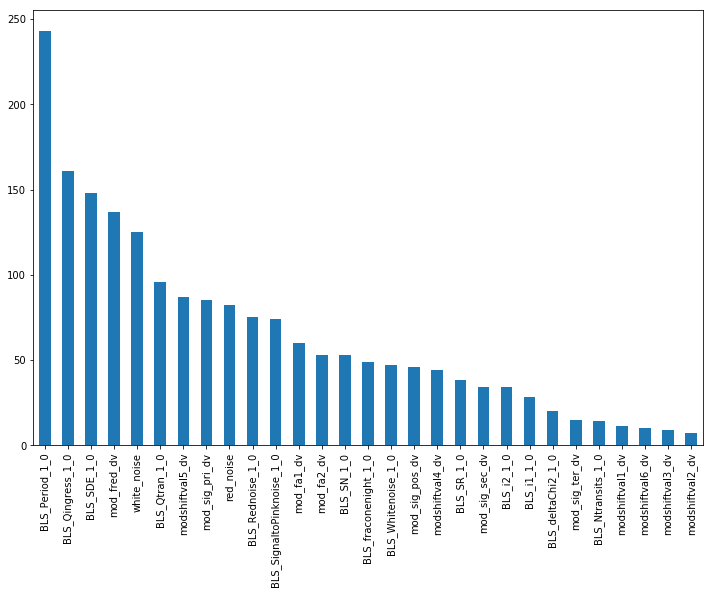

In [45]:
importances = pd.Series(xgbc.booster().get_fscore()).sort_values(ascending=False)
importances.plot(kind = "bar", figsize = (12,8))

In [60]:
# total number of strong koi in 
print ("Training Set\n")
print "Strong KOIS correctly accepted:", len(np.where((preds==1)&(testL==3)&(testY==1))[0]), "from", len(np.where((testL==3)&(testY==1))[0])


Training Set



In [57]:
# how many kois, etc were caught?
print "Strong KOIS correctly accepted:", len(np.where((preds==1)&(testL==3)&(testY==1))[0]), "from", len(np.where((testL==3)&(testY==1))[0])
print "Weak KOIS correctly rejected:" ,len(np.where((preds==0)&(testL==3)&(testY==0))[0]),"from", len(np.where((testL==3)&(testY==0))[0])

print "Injected Signals correctly accepted:" , len(np.where((preds==1)&(testL==1)&(testY==1))[0]), "from", len(np.where((testL==1)&(testY==1))[0])
print "Injected Signals correctly rejected:" , len(np.where((preds==0)&(testL==1)&(testY==0))[0]), "from", len(np.where((testL==1)&(testY==0))[0])

print "Inverted Signals correctly rejected:" , len(np.where((preds==0)&(testL==2)&(testY==0))[0]), "from", len(np.where((testL==2)&(testY==0))[0])



Strong KOIS correctly accepted: 72 from 88
Weak KOIS correctly rejected: 963 from 975
Injected Signals correctly accepted: 1352 from 1374
Injected Signals correctly rejected: 1115 from 1126
Inverted Signals correctly rejected: 3750 from 3750


In [59]:
# how many weak transits were accepted (weak by both tolerance and SNR)?
print "Inj transits with low snr and tol accepted",  len(np.where((preds==1)&(testL==1)&(testY==0))[0]), "from", len(np.where((testL==1)&(testY==0))[0])
print "Weak KOIS still accepted:", len(np.where((preds==1)&(testL==3)&(testY==0))[0]), "from", len(np.where((testL==3)&(testY==0))[0])


Inj transits with low snr and tol accepted 11 from 1126
Weak KOIS still accepted: 12 from 975


In [63]:
print len(np.where( (trainY==1) & (trainL ==3))[0])

280
